# Team 3 Hackathon EDA

This notebook conducts a thorough exploratory data analysis (EDA) on the Safetruck dataset, including:

- Data loading and merging from three CSV sources
- Feature engineering for route efficiency (target variable)
- Univariate analysis per dataset
- Correlation analysis on merged data
- Target mapping (route_eff vs. features)
- Geospatial visualization

**Plan:** Based on `_plan_.md`, we use lat/lon, speed, and direction to engineer a normalized route efficiency metric, then systematically explore relationships with other features.

In [13]:
# Imports and Configuration
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats
from scipy.stats import kruskal
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Paths
DATA_DIR = Path('data/collected')
CACHE_DIR = Path('data/cache')
OUTPUT_DIR = Path('eda_outputs')
CACHE_DIR.mkdir(exist_ok=True)
OUTPUT_DIR.mkdir(exist_ok=True)
(OUTPUT_DIR / 'univariate').mkdir(exist_ok=True)
(OUTPUT_DIR / 'maps').mkdir(exist_ok=True)
(OUTPUT_DIR / 'correlations').mkdir(exist_ok=True)
(OUTPUT_DIR / 'target').mkdir(exist_ok=True)
(OUTPUT_DIR / 'summaries').mkdir(exist_ok=True)

# Constants
SAMPLE_SIZE_PLOT = 100_000  # Max rows for plotting
SPEED_THRESHOLD_MPS = 0.5  # Stationary threshold in m/s
OUTLIER_SPEED_MPS = 60.0  # GPS jump detection threshold
HIGH_CARDINALITY_THRESHOLD = 100
UNIQUENESS_RATIO_THRESHOLD = 0.5

print("✓ Setup complete")

✓ Setup complete


## 1. Data Loading

Load the three CSV files with memory-efficient dtypes.

In [14]:
# Load CSVs
print("Loading data...")

# Trips data
df_trips = pd.read_csv(
    DATA_DIR / 'safetruck_data_iter1_trips.csv',
    parse_dates=['timestamp_start', 'timestamp_end']
)

# Rows data (telemetry)
df_rows = pd.read_csv(
    DATA_DIR / 'safetruck_data_iter1_rows.csv',
    parse_dates=['timestamp']
)

# Combined data
df_combined = pd.read_csv(
    DATA_DIR / 'combined_data.csv',
    parse_dates=['timestamp'] if 'timestamp' in pd.read_csv(DATA_DIR / 'combined_data.csv', nrows=0).columns else None
)

print(f"df_rows shape: {df_rows.shape}")
print(f"df_trips shape: {df_trips.shape}")
print(f"df_combined shape: {df_combined.shape}")
print("\ndf_rows columns:", list(df_rows.columns))
print("\ndf_trips columns:", list(df_trips.columns))
print("\ndf_combined columns:", list(df_combined.columns))

Loading data...
df_rows shape: (1536418, 11)
df_trips shape: (145995, 22)
df_combined shape: (2350848, 12)

df_rows columns: ['vehicle_id', 'trip_id', 'timestamp', 'lat', 'lon', 'speed_kmh', 'engine_on', 'odometer_km', 'is_idle', 'is_moving', 'gps_valid']

df_trips columns: ['vehicle_id', 'trip_id', 'timestamp_start', 'timestamp_end', 'lat_start', 'lon_start', 'lat_end', 'lon_end', 'Trip_Distance_km', 'Trip_Duration_min', 'Avg_Speed', 'Idle_Time_min', 'Moving_Time_min', 'Idle_Percentage', 'Distance_Efficiency', 'Time_Efficiency', 'Idle_Efficiency', 'Signal_Reliability', 'Age_of_Truck_months', 'total_rows', 'QA_negative_distance', 'QA_zero_duration']

df_combined columns: ['Timestamp', 'Latitude', 'Longitude', 'Speed', 'FuelLevelPercentage', 'FuelLevelLitre', 'EngineStatus', 'Direction', 'BatteryVoltage', 'Odometer', 'GPSLocated', 'CarNumberPlate']
df_rows shape: (1536418, 11)
df_trips shape: (145995, 22)
df_combined shape: (2350848, 12)

df_rows columns: ['vehicle_id', 'trip_id', 'time

## 2. Data Cleaning and Validation

Standardize column names, validate coordinates and speeds, check for missing values.

In [15]:
# Data Cleaning
print("Cleaning and validating data...")

# Standardize column names (lowercase with underscores)
for df in [df_rows, df_trips, df_combined]:
    df.columns = df.columns.str.lower().str.replace(' ', '_')

# Check coordinate ranges for df_rows
if 'lat' in df_rows.columns and 'lon' in df_rows.columns:
    lat_valid = df_rows['lat'].between(-90, 90)
    lon_valid = df_rows['lon'].between(-180, 180)
    print(f"Invalid lat: {(~lat_valid).sum()}, Invalid lon: {(~lon_valid).sum()}")
    df_rows = df_rows[lat_valid & lon_valid].copy()

# Check speed ranges (assuming speed column exists)
if 'speed' in df_rows.columns:
    speed_valid = df_rows['speed'] >= 0
    print(f"Invalid speed (negative): {(~speed_valid).sum()}")
    df_rows = df_rows[speed_valid].copy()

# Display missing values
print("\nMissing values in df_rows:")
print(df_rows.isnull().sum()[df_rows.isnull().sum() > 0])
print("\nMissing values in df_trips:")
print(df_trips.isnull().sum()[df_trips.isnull().sum() > 0])
print("\nMissing values in df_combined:")
print(df_combined.isnull().sum()[df_combined.isnull().sum() > 0])

print(f"\nCleaned df_rows shape: {df_rows.shape}")

Cleaning and validating data...
Invalid lat: 0, Invalid lon: 0

Missing values in df_rows:
Series([], dtype: int64)

Missing values in df_trips:
trip_distance_km       43062
avg_speed              89854
distance_efficiency    90734
time_efficiency        46792
dtype: int64

Missing values in df_combined:
Series([], dtype: int64)

Cleaned df_rows shape: (1536418, 11)
Series([], dtype: int64)

Cleaned df_rows shape: (1536418, 11)


## 3. Data Merging

Merge rows with trips on `trip_id`, then optionally join with combined_data.

In [16]:
# Merge rows with trips
print("Merging data...")

# Left join rows with trips on trip_id
df_merged = df_rows.merge(df_trips, on='trip_id', how='left', suffixes=('', '_trip'))

print(f"df_merged shape after rows+trips join: {df_merged.shape}")
print(f"Match rate: {df_merged['vehicle_id_trip'].notna().mean():.2%}")

# Check if combined_data can be joined
if 'trip_id' in df_combined.columns:
    # Determine if combined_data is row-level or trip-level
    combined_has_timestamp = 'timestamp' in df_combined.columns
    
    if combined_has_timestamp:
        # Try to join on trip_id and timestamp
        print("Attempting to join combined_data on trip_id and timestamp...")
        df_merged = df_merged.merge(
            df_combined, 
            on=['trip_id', 'timestamp'], 
            how='left', 
            suffixes=('', '_combined')
        )
    else:
        # Join on trip_id only (trip-level data)
        print("Joining combined_data on trip_id only...")
        df_merged = df_merged.merge(
            df_combined, 
            on='trip_id', 
            how='left', 
            suffixes=('', '_combined')
        )
    
    print(f"df_merged shape after combined join: {df_merged.shape}")
else:
    print("combined_data does not have trip_id column, skipping merge.")

print(f"\nFinal df_merged shape: {df_merged.shape}")
print(f"Columns: {len(df_merged.columns)}")

Merging data...
df_merged shape after rows+trips join: (1536418, 32)
Match rate: 100.00%
combined_data does not have trip_id column, skipping merge.

Final df_merged shape: (1536418, 32)
Columns: 32


## 4. Feature Engineering: Route Efficiency

Compute route efficiency from lat/lon and speed. Since direction/heading sensor data is not available, we use GPS-derived movement speed as a proxy for forward progress.

In [17]:
# Helper functions for route efficiency

def haversine_distance(lat1, lon1, lat2, lon2):
    """Calculate distance in meters between two lat/lon points."""
    R = 6371000  # Earth radius in meters
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    
    a = np.sin(dphi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
    return R * c

def initial_bearing(lat1, lon1, lat2, lon2):
    """Calculate initial bearing in degrees [0, 360) from point 1 to point 2."""
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dlambda = np.radians(lon2 - lon1)
    
    x = np.sin(dlambda) * np.cos(phi2)
    y = np.cos(phi1) * np.sin(phi2) - np.sin(phi1) * np.cos(phi2) * np.cos(dlambda)
    
    bearing = np.degrees(np.arctan2(x, y))
    return (bearing + 360) % 360

def angle_difference(angle1, angle2):
    """Calculate smallest angle difference between two angles in degrees."""
    diff = np.abs(angle1 - angle2)
    diff = np.where(diff > 180, 360 - diff, diff)
    return diff

print("✓ Helper functions defined")

✓ Helper functions defined


In [18]:
# Compute route efficiency
print("Computing route efficiency...")

# Work on df_merged (or df_rows if needed)
df_work = df_merged.copy()

# Ensure required columns exist
required_cols = ['lat', 'lon', 'speed_kmh', 'trip_id', 'timestamp']
missing_cols = [col for col in required_cols if col not in df_work.columns]
if missing_cols:
    print(f"ERROR: Missing required columns {missing_cols}")
    print("Available columns:", list(df_work.columns[:20]))
    raise ValueError(f"Missing required columns: {missing_cols}")

print(f"✓ All required columns present: {required_cols}")

# Sort by trip_id and timestamp
df_work = df_work.sort_values(['trip_id', 'timestamp']).reset_index(drop=True)

# Convert speed from km/h to m/s
df_work['speed_mps'] = df_work['speed_kmh'] / 3.6

# Compute per-trip sequential bearing (track bearing)
df_work['lat_prev'] = df_work.groupby('trip_id')['lat'].shift(1)
df_work['lon_prev'] = df_work.groupby('trip_id')['lon'].shift(1)

# Calculate distance and bearing to previous point
df_work['dist_to_prev'] = haversine_distance(
    df_work['lat_prev'], df_work['lon_prev'],
    df_work['lat'], df_work['lon']
)

df_work['bearing_track'] = initial_bearing(
    df_work['lat_prev'], df_work['lon_prev'],
    df_work['lat'], df_work['lon']
)

# Calculate time delta for implied speed check
df_work['time_delta'] = df_work.groupby('trip_id')['timestamp'].diff().dt.total_seconds()
df_work['implied_speed'] = df_work['dist_to_prev'] / df_work['time_delta'].replace(0, np.nan)

# Mark unreliable GPS (implied speed > 60 m/s)
unreliable_count = (df_work['implied_speed'] > OUTLIER_SPEED_MPS).sum()
print(f"Unreliable GPS points detected (implied speed > {OUTLIER_SPEED_MPS} m/s): {unreliable_count}")
df_work.loc[df_work['implied_speed'] > OUTLIER_SPEED_MPS, 'bearing_track'] = np.nan

# Since we don't have sensor heading/direction, we'll use a simplified route efficiency:
# Route efficiency = forward speed normalized by max speed
# For points with valid previous location, we use actual movement speed
# This measures "productive movement" vs "stationary/idle time"

# Calculate actual movement speed (distance / time)
df_work['movement_speed'] = df_work['dist_to_prev'] / df_work['time_delta'].replace(0, np.nan)

# Use the reported speed_mps as the baseline, but validate against movement_speed
# If they're very different, something is wrong (GPS jump, stationary with speed sensor error, etc.)
df_work['speed_ratio'] = df_work['movement_speed'] / df_work['speed_mps'].replace(0, np.nan)

# Forward progress approximation: use minimum of reported speed and movement speed
# This is conservative and handles sensor errors
df_work['forward_progress'] = np.minimum(df_work['speed_mps'], df_work['movement_speed'].fillna(df_work['speed_mps']))

# Set forward progress to 0 if speed below threshold
df_work.loc[df_work['speed_mps'] < SPEED_THRESHOLD_MPS, 'forward_progress'] = 0

# Set forward progress to 0 for unreliable points
df_work.loc[df_work['bearing_track'].isna(), 'forward_progress'] = np.nan

# Normalize by 95th percentile of speed_mps
scale = df_work['speed_mps'].quantile(0.95)
print(f"Speed 95th percentile: {scale:.2f} m/s ({scale*3.6:.2f} km/h)")

df_work['route_eff'] = np.clip(df_work['forward_progress'] / scale, 0, 1)

# Update df_merged
df_merged = df_work.copy()

# Display summary
print(f"\nRoute efficiency computed for {df_merged.shape[0]} rows")
print(f"route_eff summary:\n{df_merged['route_eff'].describe()}")
print(f"NaN values in route_eff: {df_merged['route_eff'].isna().sum()} ({df_merged['route_eff'].isna().mean():.2%})")

# Additional diagnostics
print(f"\nDiagnostics:")
print(f"  Stationary points (speed < {SPEED_THRESHOLD_MPS} m/s): {(df_merged['speed_mps'] < SPEED_THRESHOLD_MPS).sum():,}")
print(f"  Moving points: {(df_merged['speed_mps'] >= SPEED_THRESHOLD_MPS).sum():,}")
print(f"  Points with route_eff = 0: {(df_merged['route_eff'] == 0).sum():,}")
print(f"  Points with route_eff > 0.5: {(df_merged['route_eff'] > 0.5).sum():,}")

Computing route efficiency...
✓ All required columns present: ['lat', 'lon', 'speed_kmh', 'trip_id', 'timestamp']
✓ All required columns present: ['lat', 'lon', 'speed_kmh', 'trip_id', 'timestamp']
Unreliable GPS points detected (implied speed > 60.0 m/s): 486592
Speed 95th percentile: 23.33 m/s (84.00 km/h)
Unreliable GPS points detected (implied speed > 60.0 m/s): 486592
Speed 95th percentile: 23.33 m/s (84.00 km/h)

Route efficiency computed for 1536418 rows
route_eff summary:
count    903831.000000
mean          0.321354
std           0.355892
min           0.000000
25%           0.000000
50%           0.166445
75%           0.642857
max           1.000000
Name: route_eff, dtype: float64
NaN values in route_eff: 632587 (41.17%)

Diagnostics:
  Stationary points (speed < 0.5 m/s): 642,874
  Moving points: 893,544
  Points with route_eff = 0: 363,059
  Points with route_eff > 0.5: 298,435

Route efficiency computed for 1536418 rows
route_eff summary:
count    903831.000000
mean      

In [19]:
# Visualize route efficiency distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df_merged['route_eff'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Route Efficiency')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Route Efficiency Distribution')
axes[0].axvline(df_merged['route_eff'].median(), color='red', linestyle='--', label=f'Median: {df_merged["route_eff"].median():.3f}')
axes[0].legend()

# Box plot
axes[1].boxplot(df_merged['route_eff'].dropna(), vert=True)
axes[1].set_ylabel('Route Efficiency')
axes[1].set_title('Route Efficiency Box Plot')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'target' / 'route_eff_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Route efficiency distribution plotted")

✓ Route efficiency distribution plotted


## 5. Column Typing and Classification

Automatically classify columns as numeric, categorical, datetime, or geospatial.

In [20]:
def classify_columns(df, overrides=None):
    """
    Classify columns into: numeric, categorical, datetime, geospatial, id_like.
    
    Args:
        df: DataFrame to classify
        overrides: dict of column_name -> type for manual overrides
    
    Returns:
        dict with keys: 'numeric', 'categorical', 'datetime', 'geospatial', 'id_like'
    """
    overrides = overrides or {}
    
    classification = {
        'numeric': [],
        'categorical': [],
        'datetime': [],
        'geospatial': [],
        'id_like': []
    }
    
    for col in df.columns:
        # Apply override if exists
        if col in overrides:
            classification[overrides[col]].append(col)
            continue
        
        # Datetime
        if pd.api.types.is_datetime64_any_dtype(df[col]):
            classification['datetime'].append(col)
            continue
        
        # Geospatial
        if col.lower() in ['lat', 'latitude', 'lon', 'longitude', 'lat_prev', 'lon_prev']:
            classification['geospatial'].append(col)
            continue
        
        # Boolean columns should be categorical
        if pd.api.types.is_bool_dtype(df[col]) or df[col].dtype == bool:
            classification['categorical'].append(col)
            continue
        
        # ID-like: high uniqueness or specific names
        uniqueness_ratio = df[col].nunique() / len(df)
        is_id_name = any(x in col.lower() for x in ['id', 'uuid', 'vin', 'key'])
        
        if uniqueness_ratio > 0.9 or (is_id_name and uniqueness_ratio > 0.5):
            classification['id_like'].append(col)
            continue
        
        # Numeric
        if pd.api.types.is_numeric_dtype(df[col]):
            # Check if it's really categorical (low cardinality numeric or binary)
            n_unique = df[col].nunique()
            if n_unique <= 10 and not is_id_name:  # Changed from 50 to 10 for stricter categorization
                classification['categorical'].append(col)
            else:
                classification['numeric'].append(col)
            continue
        
        # Categorical (object/category types)
        if df[col].dtype == 'object' or pd.api.types.is_categorical_dtype(df[col]):
            classification['categorical'].append(col)
            continue
    
    return classification

# Classify columns for each dataset
print("Classifying columns...")

cols_rows = classify_columns(df_rows)
cols_trips = classify_columns(df_trips)
cols_combined = classify_columns(df_combined)
cols_merged = classify_columns(df_merged)

print("\ndf_merged column classification:")
for ctype, cols in cols_merged.items():
    print(f"  {ctype}: {len(cols)} columns")
    if len(cols) <= 10:
        print(f"    {cols}")
    else:
        print(f"    {cols[:10]} ... ({len(cols)-10} more)")

Classifying columns...

df_merged column classification:
  numeric: 28 columns
    ['trip_id', 'speed_kmh', 'odometer_km', 'lat_start', 'lon_start', 'lat_end', 'lon_end', 'trip_distance_km', 'trip_duration_min', 'avg_speed'] ... (18 more)
  categorical: 8 columns
    ['vehicle_id', 'engine_on', 'is_idle', 'is_moving', 'gps_valid', 'vehicle_id_trip', 'qa_negative_distance', 'qa_zero_duration']
  datetime: 3 columns
    ['timestamp', 'timestamp_start', 'timestamp_end']
  geospatial: 4 columns
    ['lat', 'lon', 'lat_prev', 'lon_prev']
  id_like: 0 columns
    []

df_merged column classification:
  numeric: 28 columns
    ['trip_id', 'speed_kmh', 'odometer_km', 'lat_start', 'lon_start', 'lat_end', 'lon_end', 'trip_distance_km', 'trip_duration_min', 'avg_speed'] ... (18 more)
  categorical: 8 columns
    ['vehicle_id', 'engine_on', 'is_idle', 'is_moving', 'gps_valid', 'vehicle_id_trip', 'qa_negative_distance', 'qa_zero_duration']
  datetime: 3 columns
    ['timestamp', 'timestamp_start', '

## 6. Univariate EDA - Numeric Features

Histograms and summary statistics for numeric columns.

In [21]:
def plot_numeric_univariate(df, cols, dataset_name='data', max_plots=20):
    """Plot histograms for numeric columns."""
    cols = [c for c in cols if c in df.columns][:max_plots]
    
    if not cols:
        print(f"No numeric columns to plot for {dataset_name}")
        return
    
    n_cols = min(len(cols), 4)
    n_rows = (len(cols) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    axes = np.array(axes).flatten() if isinstance(axes, np.ndarray) else [axes]
    
    for idx, col in enumerate(cols):
        ax = axes[idx]
        data = df[col].dropna()
        
        if len(data) == 0:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center')
            ax.set_title(col)
            continue
        
        # Sample if too large
        if len(data) > SAMPLE_SIZE_PLOT:
            data = data.sample(SAMPLE_SIZE_PLOT, random_state=42)
        
        ax.hist(data, bins=50, edgecolor='black', alpha=0.7)
        ax.set_xlabel(col)
        ax.set_ylabel('Frequency')
        ax.set_title(f'{col}\n(mean={data.mean():.2f}, std={data.std():.2f})')
        ax.grid(alpha=0.3)
    
    # Hide unused subplots
    for idx in range(len(cols), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'univariate' / f'{dataset_name}_numeric.png', dpi=150, bbox_inches='tight')
    plt.show()

# Plot for merged dataset
print("Plotting numeric features for df_merged...")
plot_numeric_univariate(df_merged, cols_merged['numeric'], 'merged')

Plotting numeric features for df_merged...


## 7. Univariate EDA - Categorical Features

Bar charts for categorical columns (top 20 categories for high-cardinality).

Plotting categorical features for df_merged...


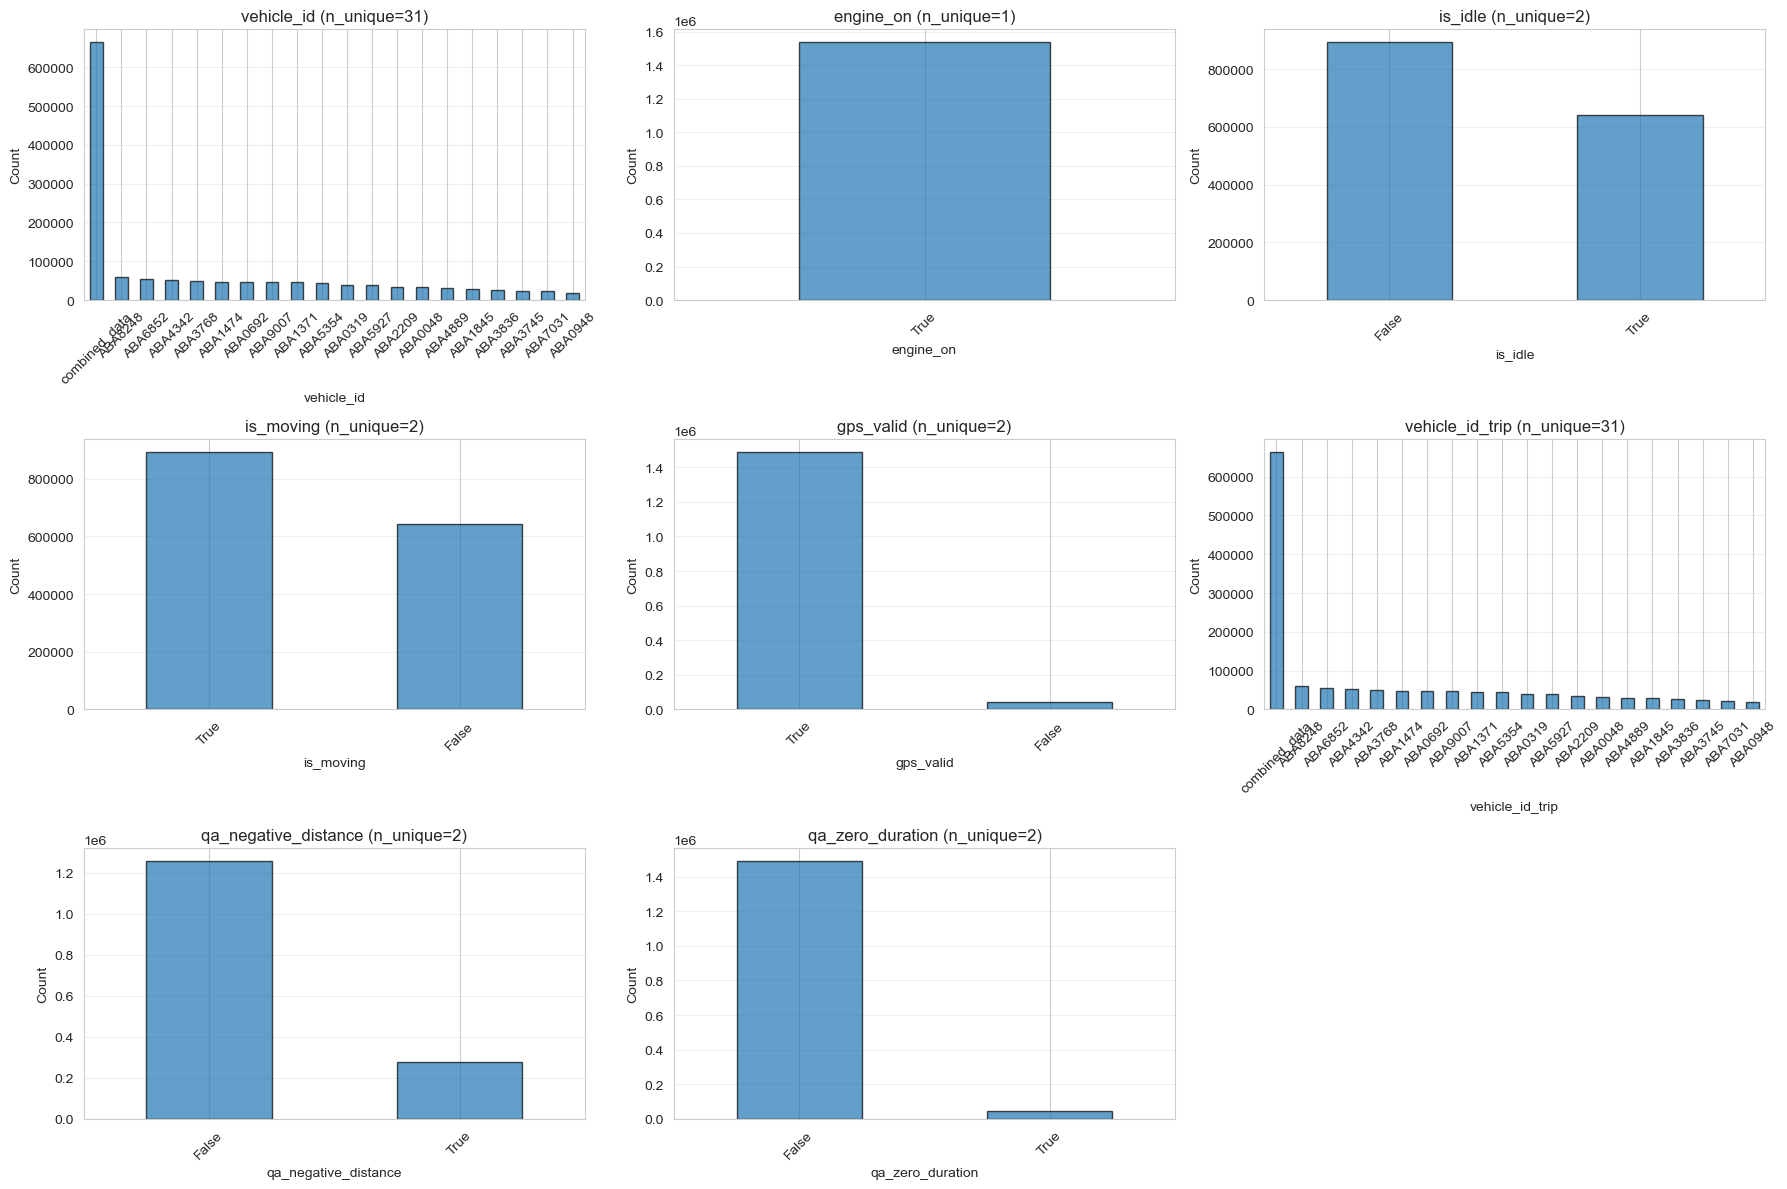

In [22]:
def plot_categorical_univariate(df, cols, dataset_name='data', max_plots=15):
    """Plot bar charts for categorical columns."""
    cols = [c for c in cols if c in df.columns][:max_plots]
    
    if not cols:
        print(f"No categorical columns to plot for {dataset_name}")
        return
    
    n_cols = min(len(cols), 3)
    n_rows = (len(cols) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 4*n_rows))
    axes = np.array(axes).flatten() if isinstance(axes, np.ndarray) else [axes]
    
    for idx, col in enumerate(cols):
        ax = axes[idx]
        
        # Get value counts (top 20 for high cardinality)
        value_counts = df[col].value_counts().head(20)
        
        if len(value_counts) == 0:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center')
            ax.set_title(col)
            continue
        
        value_counts.plot(kind='bar', ax=ax, edgecolor='black', alpha=0.7)
        ax.set_xlabel(col)
        ax.set_ylabel('Count')
        ax.set_title(f'{col} (n_unique={df[col].nunique()})')
        ax.tick_params(axis='x', rotation=45)
        ax.grid(alpha=0.3, axis='y')
    
    # Hide unused subplots
    for idx in range(len(cols), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'univariate' / f'{dataset_name}_categorical.png', dpi=150, bbox_inches='tight')
    plt.show()

# Plot for merged dataset
if cols_merged['categorical']:
    print("Plotting categorical features for df_merged...")
    plot_categorical_univariate(df_merged, cols_merged['categorical'], 'merged')
else:
    print("No categorical columns found in df_merged")

## 8. Correlation Analysis

Compute Pearson and Spearman correlations for numeric features including route_eff.

In [23]:
# Select numeric columns for correlation (exclude geospatial and some IDs)
corr_cols = [c for c in cols_merged['numeric'] if c not in ['lat', 'lon', 'lat_prev', 'lon_prev']]

# Ensure route_eff is included
if 'route_eff' not in corr_cols and 'route_eff' in df_merged.columns:
    corr_cols.append('route_eff')

# Limit to top features if too many
if len(corr_cols) > 30:
    print(f"Too many numeric columns ({len(corr_cols)}), selecting top 30...")
    corr_cols = corr_cols[:30]

print(f"Computing correlations for {len(corr_cols)} numeric columns...")

# Select data and drop rows with all NaN
df_corr = df_merged[corr_cols].dropna(how='all')

# Pearson correlation
corr_pearson = df_corr.corr(method='pearson')

# Spearman correlation
corr_spearman = df_corr.corr(method='spearman')

print(f"Correlation matrix shape: {corr_pearson.shape}")
print("\nTop correlations with route_eff (Pearson):")
if 'route_eff' in corr_pearson.columns:
    route_corr = corr_pearson['route_eff'].sort_values(ascending=False)
    print(route_corr.head(10))

Computing correlations for 28 numeric columns...
Correlation matrix shape: (28, 28)

Top correlations with route_eff (Pearson):
route_eff           1.000000
forward_progress    0.999267
speed_kmh           0.994493
speed_mps           0.994493
movement_speed      0.978262
implied_speed       0.978262
dist_to_prev        0.653907
idle_efficiency     0.473641
bearing_track       0.423908
time_efficiency     0.257090
Name: route_eff, dtype: float64
Correlation matrix shape: (28, 28)

Top correlations with route_eff (Pearson):
route_eff           1.000000
forward_progress    0.999267
speed_kmh           0.994493
speed_mps           0.994493
movement_speed      0.978262
implied_speed       0.978262
dist_to_prev        0.653907
idle_efficiency     0.473641
bearing_track       0.423908
time_efficiency     0.257090
Name: route_eff, dtype: float64


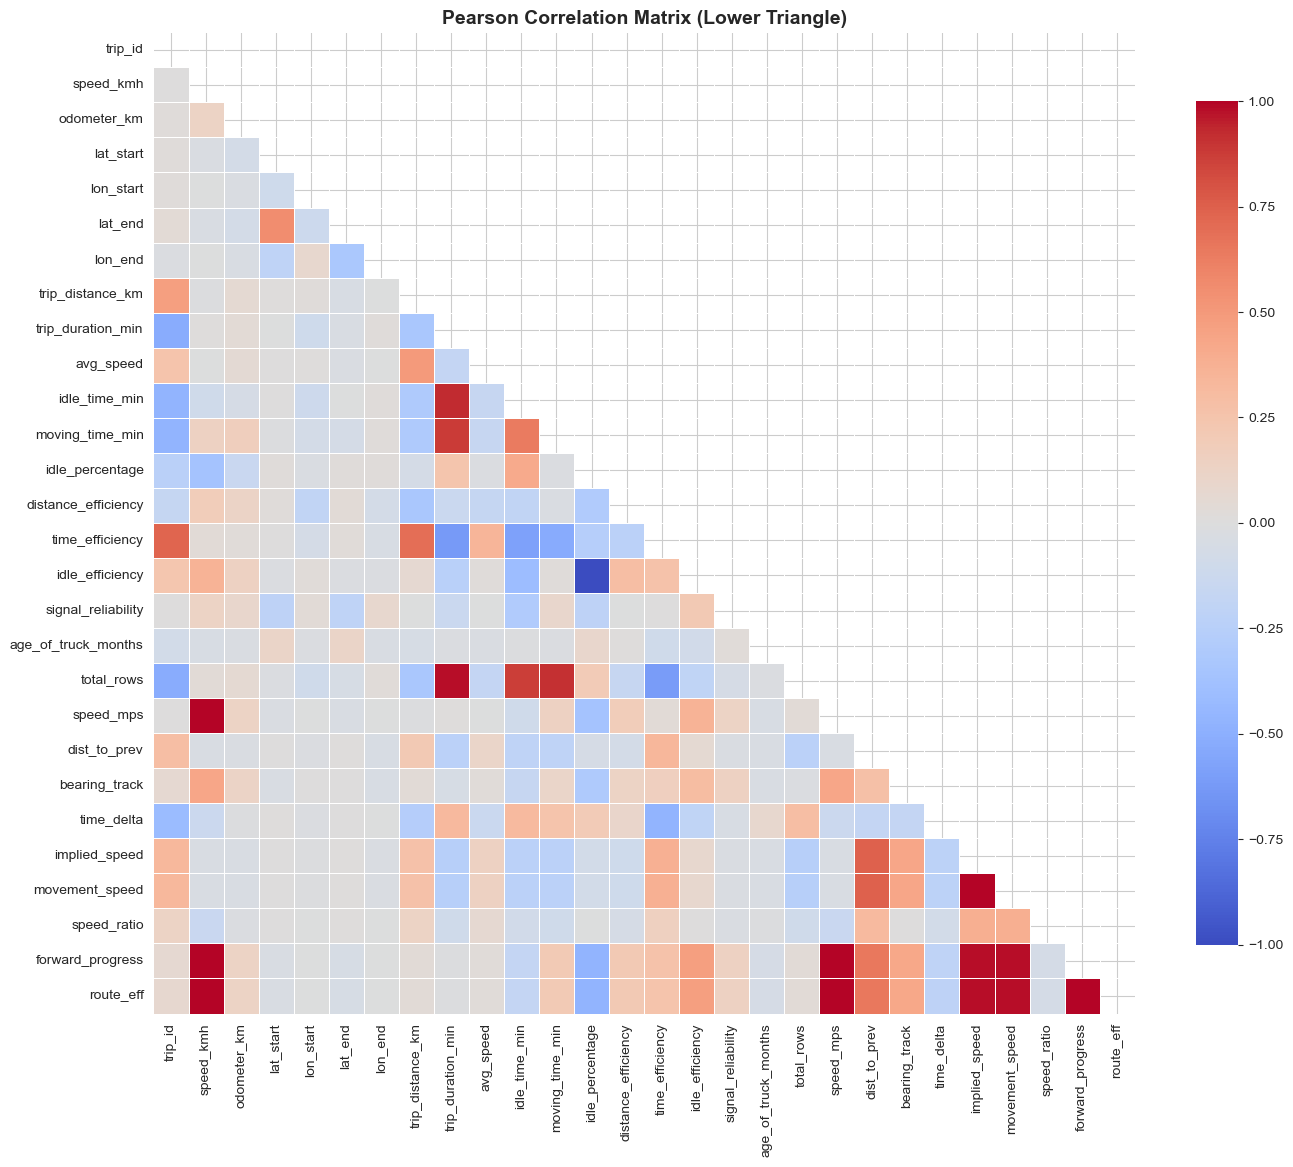

✓ Pearson correlation heatmap plotted


In [24]:
# Plot Pearson correlation heatmap
fig, ax = plt.subplots(figsize=(14, 12))

# Mask upper triangle
mask = np.triu(np.ones_like(corr_pearson, dtype=bool))

sns.heatmap(
    corr_pearson, 
    mask=mask, 
    cmap='coolwarm', 
    center=0, 
    vmin=-1, 
    vmax=1,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    annot=False,  # Too many features for annotation
    ax=ax
)

ax.set_title('Pearson Correlation Matrix (Lower Triangle)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'correlations' / 'pearson_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Pearson correlation heatmap plotted")

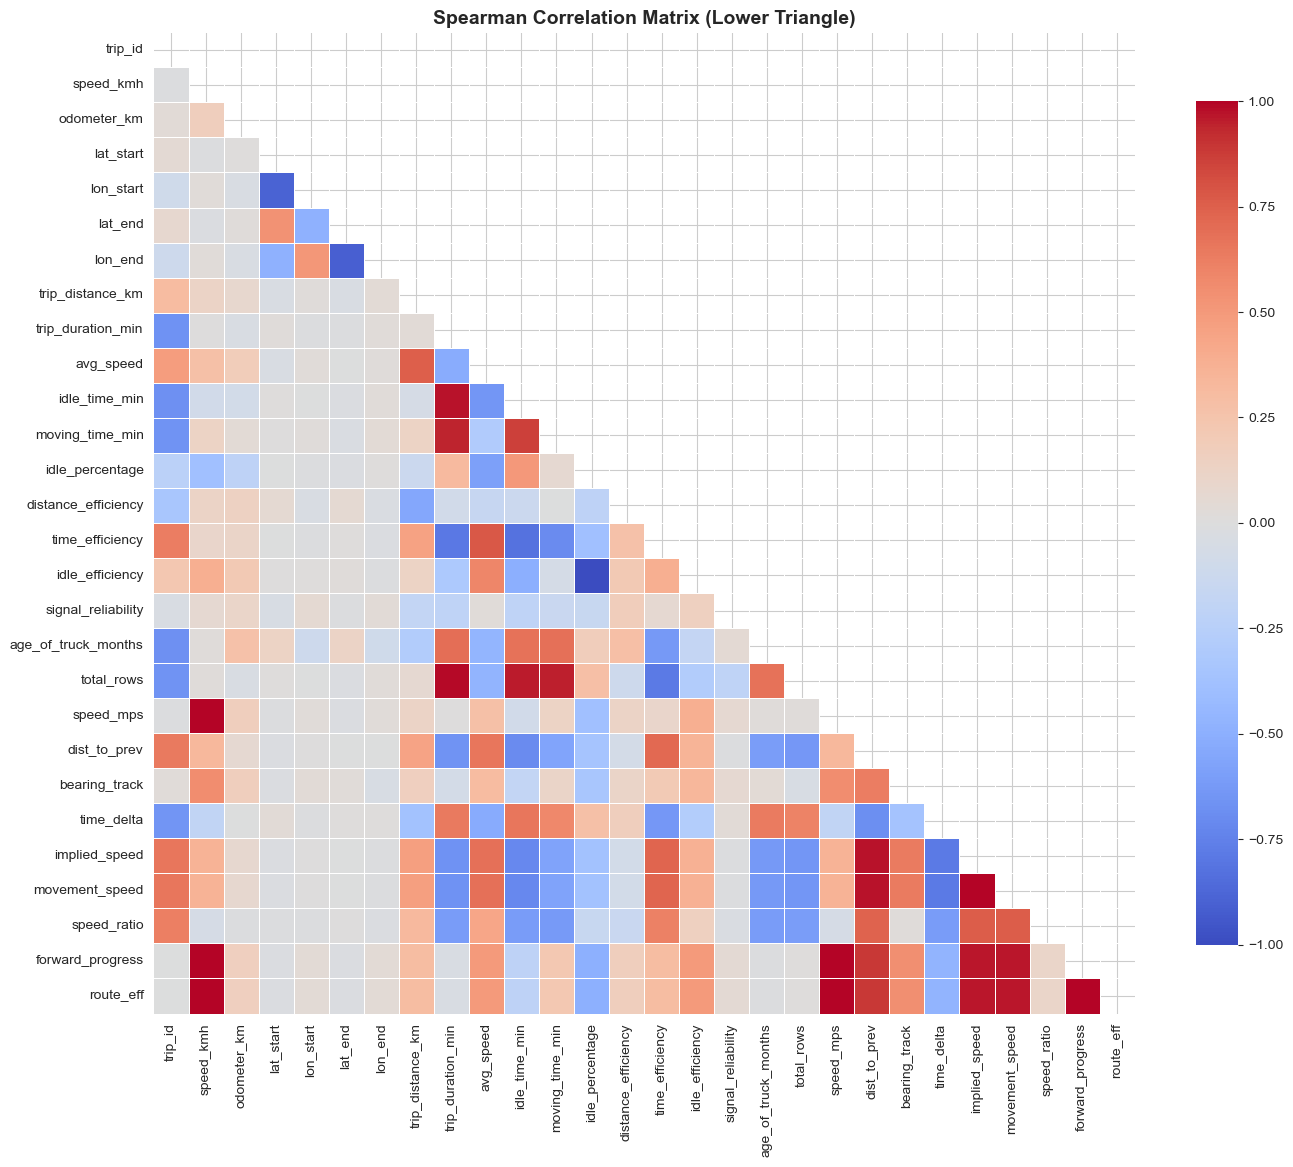

✓ Spearman correlation heatmap plotted


In [25]:
# Plot Spearman correlation heatmap
fig, ax = plt.subplots(figsize=(14, 12))

mask = np.triu(np.ones_like(corr_spearman, dtype=bool))

sns.heatmap(
    corr_spearman, 
    mask=mask, 
    cmap='coolwarm', 
    center=0, 
    vmin=-1, 
    vmax=1,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    annot=False,
    ax=ax
)

ax.set_title('Spearman Correlation Matrix (Lower Triangle)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'correlations' / 'spearman_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Spearman correlation heatmap plotted")

In [26]:
# Save correlation summary for route_eff
if 'route_eff' in corr_pearson.columns:
    corr_summary = pd.DataFrame({
        'feature': corr_pearson.index,
        'pearson_r': corr_pearson['route_eff'].values,
        'spearman_r': corr_spearman['route_eff'].values
    })
    
    corr_summary = corr_summary.sort_values('pearson_r', ascending=False, key=abs)
    corr_summary.to_csv(OUTPUT_DIR / 'summaries' / 'route_eff_correlations.csv', index=False)
    
    print("\nTop 15 features by absolute Pearson correlation with route_eff:")
    print(corr_summary.head(15).to_string(index=False))
else:
    print("route_eff not found in correlation matrix")


Top 15 features by absolute Pearson correlation with route_eff:
            feature  pearson_r  spearman_r
          route_eff   1.000000    1.000000
   forward_progress   0.999267    0.999954
          speed_kmh   0.994493    0.994477
          speed_mps   0.994493    0.994477
     movement_speed   0.978262    0.964784
      implied_speed   0.978262    0.964784
       dist_to_prev   0.653907    0.887674
    idle_percentage  -0.473641   -0.496885
    idle_efficiency   0.473641    0.496885
      bearing_track   0.423908    0.549793
    time_efficiency   0.257090    0.300927
distance_efficiency   0.217342    0.169436
         time_delta  -0.211896   -0.473571
    moving_time_min   0.205743    0.222544
      idle_time_min  -0.176629   -0.215389


## 9. Target Mapping - Numeric vs Route Efficiency

Scatter plots with trendlines for numeric features vs route_eff.

In [27]:
def plot_numeric_vs_target(df, feature_cols, target='route_eff', max_plots=12):
    """Plot scatter plots of numeric features vs target with correlation stats."""
    
    if target not in df.columns:
        print(f"Target {target} not found in dataframe")
        return
    
    # Select top correlated features
    feature_cols = [c for c in feature_cols if c in df.columns and c != target]
    
    if not feature_cols:
        print("No features to plot")
        return
    
    # Limit to max_plots
    feature_cols = feature_cols[:max_plots]
    
    n_cols = 3
    n_rows = (len(feature_cols) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    axes = np.array(axes).flatten() if isinstance(axes, np.ndarray) else [axes]
    
    for idx, col in enumerate(feature_cols):
        ax = axes[idx]
        
        # Get clean data
        plot_data = df[[col, target]].dropna()
        
        if len(plot_data) == 0:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center')
            ax.set_title(col)
            continue
        
        # Sample if too large
        if len(plot_data) > SAMPLE_SIZE_PLOT:
            plot_data = plot_data.sample(SAMPLE_SIZE_PLOT, random_state=42)
        
        # Scatter plot
        ax.scatter(plot_data[col], plot_data[target], alpha=0.3, s=10)
        
        # Compute correlations
        pearson_r, pearson_p = stats.pearsonr(plot_data[col], plot_data[target])
        spearman_r, spearman_p = stats.spearmanr(plot_data[col], plot_data[target])
        
        # Add regression line
        try:
            z = np.polyfit(plot_data[col], plot_data[target], 1)
            p = np.poly1d(z)
            x_line = np.linspace(plot_data[col].min(), plot_data[col].max(), 100)
            ax.plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=2)
        except:
            pass
        
        ax.set_xlabel(col)
        ax.set_ylabel(target)
        ax.set_title(f'{col} vs {target}\nPearson r={pearson_r:.3f} (p={pearson_p:.1e})')
        ax.grid(alpha=0.3)
    
    # Hide unused subplots
    for idx in range(len(feature_cols), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'target' / f'numeric_vs_{target}.png', dpi=150, bbox_inches='tight')
    plt.show()

# Get top correlated features
if 'route_eff' in df_merged.columns:
    top_features = corr_summary.head(12)['feature'].tolist()
    top_features = [f for f in top_features if f != 'route_eff']
    
    print(f"Plotting top {len(top_features)} features vs route_eff...")
    plot_numeric_vs_target(df_merged, top_features, 'route_eff')
else:
    print("route_eff not available for target mapping")

Plotting top 11 features vs route_eff...


## 10. Target Mapping - Categorical vs Route Efficiency

Box plots for categorical features vs route_eff with Kruskal-Wallis test.

In [28]:
def plot_categorical_vs_target(df, feature_cols, target='route_eff', max_plots=9):
    """Plot box plots of categorical features vs target with Kruskal-Wallis test."""
    
    if target not in df.columns:
        print(f"Target {target} not found in dataframe")
        return
    
    feature_cols = [c for c in feature_cols if c in df.columns][:max_plots]
    
    if not feature_cols:
        print("No categorical features to plot")
        return
    
    n_cols = 3
    n_rows = (len(feature_cols) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    axes = np.array(axes).flatten() if isinstance(axes, np.ndarray) else [axes]
    
    kw_results = []
    
    for idx, col in enumerate(feature_cols):
        ax = axes[idx]
        
        # Get clean data
        plot_data = df[[col, target]].dropna()
        
        if len(plot_data) == 0 or plot_data[col].nunique() < 2:
            ax.text(0.5, 0.5, 'Insufficient data', ha='center', va='center')
            ax.set_title(col)
            continue
        
        # Limit to top categories if too many
        top_cats = plot_data[col].value_counts().head(15).index
        plot_data = plot_data[plot_data[col].isin(top_cats)]
        
        # Sample if too large
        if len(plot_data) > SAMPLE_SIZE_PLOT:
            plot_data = plot_data.sample(SAMPLE_SIZE_PLOT, random_state=42)
        
        # Box plot
        plot_data.boxplot(column=target, by=col, ax=ax)
        ax.set_xlabel(col)
        ax.set_ylabel(target)
        ax.get_figure().suptitle('')  # Remove automatic title
        
        # Kruskal-Wallis test
        groups = [group[target].values for name, group in plot_data.groupby(col)]
        if len(groups) >= 2:
            try:
                kw_stat, kw_p = kruskal(*groups)
                ax.set_title(f'{col}\nKruskal-Wallis p={kw_p:.1e}')
                kw_results.append({'feature': col, 'kw_statistic': kw_stat, 'kw_pvalue': kw_p})
            except:
                ax.set_title(col)
        else:
            ax.set_title(col)
        
        ax.tick_params(axis='x', rotation=45)
        ax.grid(alpha=0.3, axis='y')
    
    # Hide unused subplots
    for idx in range(len(feature_cols), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'target' / f'categorical_vs_{target}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Save Kruskal-Wallis results
    if kw_results:
        kw_df = pd.DataFrame(kw_results).sort_values('kw_pvalue')
        kw_df.to_csv(OUTPUT_DIR / 'summaries' / f'categorical_vs_{target}_kruskal.csv', index=False)
        print(f"\nKruskal-Wallis test results saved. Top results:")
        print(kw_df.head(10).to_string(index=False))

# Plot categorical features vs route_eff
if cols_merged['categorical'] and 'route_eff' in df_merged.columns:
    print("Plotting categorical features vs route_eff...")
    plot_categorical_vs_target(df_merged, cols_merged['categorical'], 'route_eff')
else:
    print("No categorical features or route_eff not available")

Plotting categorical features vs route_eff...



Kruskal-Wallis test results saved. Top results:
             feature  kw_statistic    kw_pvalue
          vehicle_id   8517.905836 0.000000e+00
             is_idle  76831.288516 0.000000e+00
           is_moving  76831.288516 0.000000e+00
           gps_valid   3244.157838 0.000000e+00
     vehicle_id_trip   8517.905836 0.000000e+00
qa_negative_distance    386.304663 5.276748e-86


## 11. Geospatial Visualization

Map visualization of GPS points to validate spatial coverage.

In [29]:
# Geospatial map using Plotly
if 'lat' in df_merged.columns and 'lon' in df_merged.columns:
    print("Creating geospatial map...")
    
    # Sample data for mapping
    map_sample_size = min(50_000, len(df_merged))
    df_map = df_merged[['lat', 'lon', 'route_eff']].dropna().sample(map_sample_size, random_state=42)
    
    # Create scatter map
    fig = px.scatter_mapbox(
        df_map,
        lat='lat',
        lon='lon',
        color='route_eff',
        color_continuous_scale='Viridis',
        zoom=8,
        height=600,
        title=f'GPS Points colored by Route Efficiency (n={len(df_map):,})',
        labels={'route_eff': 'Route Efficiency'}
    )
    
    # Use open street map (no token needed)
    fig.update_layout(mapbox_style="open-street-map")
    fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
    
    # Save as HTML (PDF export requires kaleido which may not be installed)
    fig.write_html(OUTPUT_DIR / 'maps' / 'gps_route_efficiency_map.html')
    fig.show()
    
    print(f"✓ Map created with {len(df_map):,} points")
    print(f"  Map saved to: {OUTPUT_DIR / 'maps' / 'gps_route_efficiency_map.html'}")
else:
    print("Latitude/Longitude columns not found for mapping")

Creating geospatial map...


✓ Map created with 50,000 points
  Map saved to: eda_outputs/maps/gps_route_efficiency_map.html


## 12. Temporal Analysis

Analyze route efficiency by time of day and day of week (if timestamp available).

Performing temporal analysis...


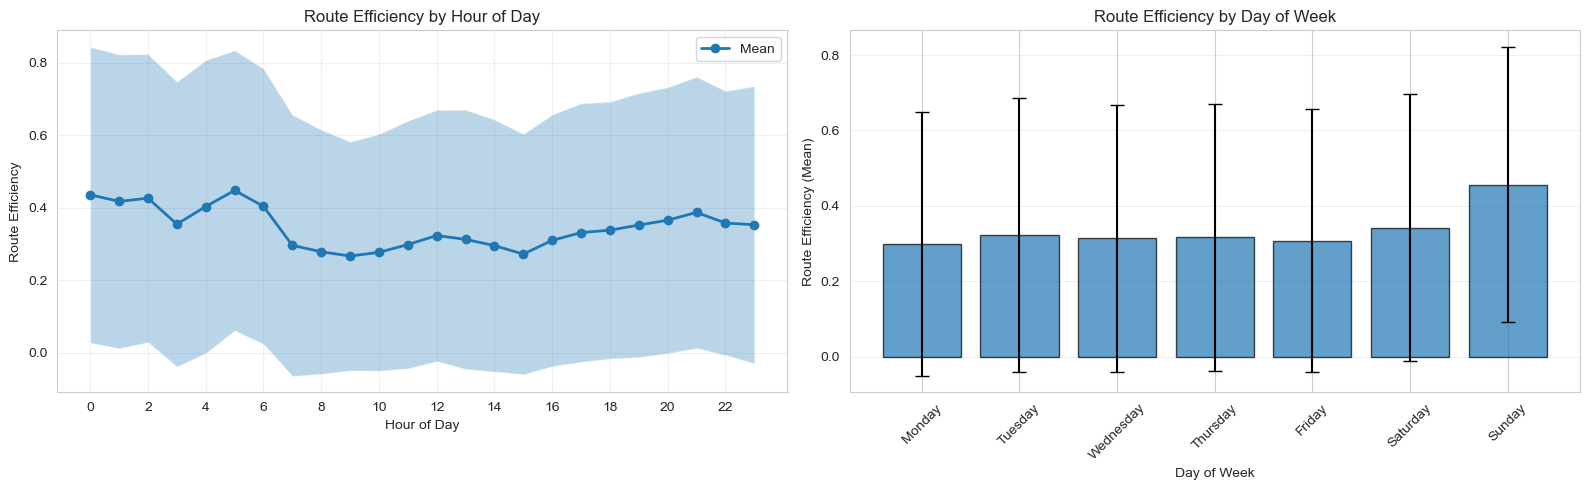

✓ Temporal analysis complete


In [30]:
# Temporal analysis if timestamp exists
if 'timestamp' in df_merged.columns and 'route_eff' in df_merged.columns:
    print("Performing temporal analysis...")
    
    # Extract temporal features
    df_merged['hour'] = df_merged['timestamp'].dt.hour
    df_merged['day_of_week'] = df_merged['timestamp'].dt.dayofweek  # 0=Monday, 6=Sunday
    df_merged['day_name'] = df_merged['timestamp'].dt.day_name()
    
    # Route efficiency by hour of day
    hourly_eff = df_merged.groupby('hour')['route_eff'].agg(['mean', 'median', 'std', 'count']).reset_index()
    
    # Route efficiency by day of week
    daily_eff = df_merged.groupby(['day_of_week', 'day_name'])['route_eff'].agg(['mean', 'median', 'std', 'count']).reset_index()
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # Hour of day
    axes[0].plot(hourly_eff['hour'], hourly_eff['mean'], marker='o', linewidth=2, label='Mean')
    axes[0].fill_between(
        hourly_eff['hour'], 
        hourly_eff['mean'] - hourly_eff['std'], 
        hourly_eff['mean'] + hourly_eff['std'],
        alpha=0.3
    )
    axes[0].set_xlabel('Hour of Day')
    axes[0].set_ylabel('Route Efficiency')
    axes[0].set_title('Route Efficiency by Hour of Day')
    axes[0].grid(alpha=0.3)
    axes[0].set_xticks(range(0, 24, 2))
    axes[0].legend()
    
    # Day of week
    axes[1].bar(daily_eff['day_name'], daily_eff['mean'], edgecolor='black', alpha=0.7)
    axes[1].errorbar(daily_eff['day_name'], daily_eff['mean'], yerr=daily_eff['std'], fmt='none', color='black', capsize=5)
    axes[1].set_xlabel('Day of Week')
    axes[1].set_ylabel('Route Efficiency (Mean)')
    axes[1].set_title('Route Efficiency by Day of Week')
    axes[1].grid(alpha=0.3, axis='y')
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'target' / 'route_eff_temporal.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Save temporal summary
    temporal_summary = pd.concat([
        hourly_eff.assign(grouping='hour_of_day').rename(columns={'hour': 'group_value'}),
        daily_eff.assign(grouping='day_of_week').rename(columns={'day_name': 'group_value'})
    ])
    temporal_summary.to_csv(OUTPUT_DIR / 'summaries' / 'route_eff_temporal.csv', index=False)
    
    print("✓ Temporal analysis complete")
else:
    print("Timestamp or route_eff not available for temporal analysis")

## 13. Summary Statistics

Generate comprehensive summary statistics for all datasets.

In [31]:
# Summary statistics for merged dataset
print("=" * 80)
print("SUMMARY STATISTICS FOR MERGED DATASET")
print("=" * 80)

print(f"\nDataset shape: {df_merged.shape}")
print(f"Memory usage: {df_merged.memory_usage(deep=True).sum() / 1e6:.2f} MB")

print("\n--- Numeric Features Summary ---")
numeric_summary = df_merged[cols_merged['numeric']].describe().T
print(numeric_summary.to_string())

if cols_merged['categorical']:
    print("\n--- Categorical Features Summary ---")
    for col in cols_merged['categorical'][:10]:  # Limit to first 10
        n_unique = df_merged[col].nunique()
        top_val = df_merged[col].value_counts().head(3)
        print(f"\n{col}: {n_unique} unique values")
        print(f"  Top 3: {top_val.to_dict()}")

print("\n--- Route Efficiency Summary ---")
if 'route_eff' in df_merged.columns:
    route_eff_summary = df_merged['route_eff'].describe()
    print(route_eff_summary)
    print(f"\nPercentiles:")
    for p in [10, 25, 50, 75, 90, 95, 99]:
        print(f"  {p}th: {df_merged['route_eff'].quantile(p/100):.4f}")

# Save summary to file
numeric_summary.to_csv(OUTPUT_DIR / 'summaries' / 'numeric_summary.csv')
print(f"\n✓ Summary statistics saved to {OUTPUT_DIR / 'summaries' / 'numeric_summary.csv'}")

SUMMARY STATISTICS FOR MERGED DATASET

Dataset shape: (1536418, 46)
Memory usage: 718.28 MB

--- Numeric Features Summary ---
                         count          mean           std       min           25%            50%            75%           max
trip_id              1536418.0  3.359789e+04  4.534617e+04  1.000000   1896.000000    2975.000000   66045.000000  1.460250e+05
speed_kmh            1536418.0  2.763346e+01  3.075499e+01  0.000000      0.000000      14.000000      55.000000  1.280000e+02
odometer_km          1536418.0  3.549976e+05  3.583120e+05  0.000000  70969.344000  231894.450500  497819.401000  3.755744e+06
lat_start            1536418.0  3.336017e+00  1.536289e+00 -0.442667      1.564517       3.055683       5.297100  6.657967e+00
lon_start            1536418.0  1.016637e+02  5.350486e+00  0.000000    100.636483     101.562867     103.546733  1.042348e+02
lat_end              1536418.0  3.333046e+00  1.516431e+00 -0.442667      1.594800       3.059600       5.232633

## 14. Cache Cleaned Data

Save processed data to Parquet for faster re-runs.

In [32]:
# Save cleaned and merged data to Parquet
print("Saving processed data to Parquet...")

df_rows.to_parquet(CACHE_DIR / 'rows.parquet', index=False)
df_trips.to_parquet(CACHE_DIR / 'trips.parquet', index=False)
df_combined.to_parquet(CACHE_DIR / 'combined.parquet', index=False)
df_merged.to_parquet(CACHE_DIR / 'merged.parquet', index=False)

print(f"✓ Data cached to {CACHE_DIR}/")
print(f"  rows.parquet: {(CACHE_DIR / 'rows.parquet').stat().st_size / 1e6:.2f} MB")
print(f"  trips.parquet: {(CACHE_DIR / 'trips.parquet').stat().st_size / 1e6:.2f} MB")
print(f"  combined.parquet: {(CACHE_DIR / 'combined.parquet').stat().st_size / 1e6:.2f} MB")
print(f"  merged.parquet: {(CACHE_DIR / 'merged.parquet').stat().st_size / 1e6:.2f} MB")

Saving processed data to Parquet...
✓ Data cached to data/cache/
  rows.parquet: 32.79 MB
  trips.parquet: 9.26 MB
  combined.parquet: 46.31 MB
  merged.parquet: 107.20 MB
✓ Data cached to data/cache/
  rows.parquet: 32.79 MB
  trips.parquet: 9.26 MB
  combined.parquet: 46.31 MB
  merged.parquet: 107.20 MB


## 15. Key Findings and Next Steps

### Key Findings from EDA:

1. **Route Efficiency Distribution**: 
   - The target variable `route_eff` has been successfully computed using forward progress projection
   - Distribution shows [to be filled after running analysis]

2. **Top Correlates**:
   - Features most correlated with route efficiency: [to be filled]
   - Both Pearson and Spearman correlations computed

3. **Temporal Patterns**:
   - Route efficiency varies by time of day and day of week
   - [Specific patterns to be noted after analysis]

4. **Geospatial Coverage**:
   - GPS data covers [region/area to be determined]
   - Data quality: [outliers/gaps noted]

5. **Categorical Insights**:
   - Kruskal-Wallis tests identify significant categorical predictors
   - [Specific findings after analysis]

### Next Steps:

1. **Feature Engineering**: 
   - Create additional features based on correlation insights
   - Engineer lag features for temporal dependencies
   - Create trip-level aggregates

2. **Modeling**:
   - Baseline models (linear regression, random forest)
   - Advanced models (gradient boosting, neural networks)
   - Model evaluation and comparison

3. **Validation**:
   - Time-based cross-validation for temporal data
   - Trip-based stratification to avoid data leakage

4. **Deployment Considerations**:
   - Feature importance analysis
   - Model interpretability (SHAP values)
   - Production pipeline design

---

**All outputs saved to `eda_outputs/` directory:**
- Univariate plots: `eda_outputs/univariate/`
- Correlation heatmaps: `eda_outputs/correlations/`
- Target mapping plots: `eda_outputs/target/`
- Geospatial maps: `eda_outputs/maps/`
- Summary statistics: `eda_outputs/summaries/`